# Робота з неперервними змінними

&emsp;&emsp;Для ілюстрації прикладів скористаємося моделлю лінійної регресії, яка оцінює вартість квадратного метра нерухомості:

In [66]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt

In [67]:
# прочитаємо дані з файлу
data = pd.read_csv('RealEstate.csv', sep=',', header=0)

# оберемо незалежні змінні
X = data[['X2 house age', 'X3 distance to the nearest MRT station',
          'X4 number of convenience stores', 'X1 transaction date']]

# виберемо цільову змінну
y = data['Y house price of unit area'].values

In [68]:
# розділимо дані на 2 набори: навчальну та тестову групу
X_train, X_test, y_train, y_test = train_test_split(
    X,  # перший масив, який потрібно розділити
    y,  # другий масив, який потрібно роздолити
    test_size=0.2,  # розмір меншої групи (20% від загальної кількості даних)
    random_state=42  # фіксація випадкового стану: тепер при перезапуску групи будуть однаковими
)

# формальність для того, щоб не бачити попередження про зміни на зрізі з таблиці
X_train, X_test = X_train.copy(), X_test.copy()

In [69]:
# побудуємо модель
mdl = LinearRegression().fit(X_train, y_train)

# оцінимо точність моделі
train_predictions = mdl.predict(X_train)
test_predictions = mdl.predict(X_test)

print('Помилка на навчальному наборі: ', mean_squared_error(y_train, train_predictions))
print('Помилка на тестовому наборі: ', mean_squared_error(y_test, test_predictions))

Помилка на навчальному наборі:  88.6734346626267
Помилка на тестовому наборі:  56.11619009787597


&emsp;&emsp;Маючи базову модель, можемо приступати до поліпшень.

&emsp;&emsp;Перше про що варто сказати - більшість моделей, які не засновані на деревах прийняття рішень (моделі лінійної та логістичної регресії, нейронні мережі та багато інших), краще працюють, коли змінні нормально розподілені.

&emsp;&emsp;Подивимось на розподіл наших змінних:

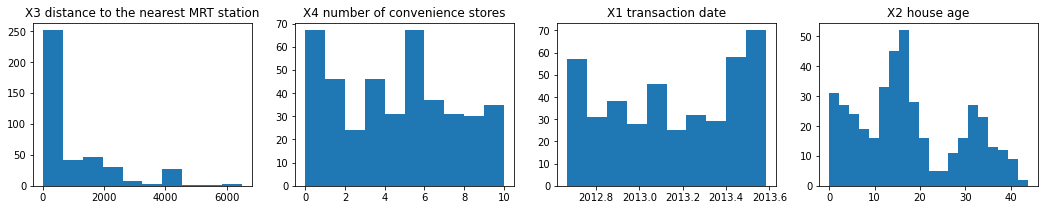

In [74]:
plt.figure(figsize=(18, 3))

plt.subplot(141)
plt.hist(X['X3 distance to the nearest MRT station'])
plt.title('X3 distance to the nearest MRT station')

plt.subplot(142)
plt.hist(X['X4 number of convenience stores'])
plt.title('X4 number of convenience stores')

plt.subplot(143)
plt.hist(X['X1 transaction date'])
plt.title('X1 transaction date')

plt.subplot(144)
plt.hist(X['X2 house age'], bins=20)
plt.title('X2 house age')

plt.show()

&emsp;&emsp;Вік будинку, схоже, містить усередині 2 кластери; до нього ми повернемося згодом. Відстань до найближчої станції виглядає швидше як логнормальний або експоненційний розподіл. Зазвичай, такий розподіл можна приблизно привести до нормального за допомогою логарифмування:

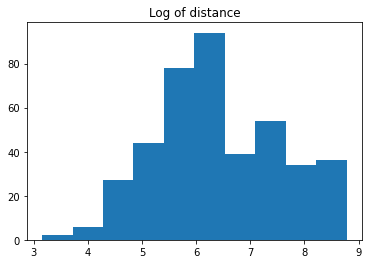

In [75]:
import numpy as np

plt.hist(np.log(X['X3 distance to the nearest MRT station']))
plt.title('Log of distance')
plt.show()

&emsp;&emsp;Спробуємо додати цю зміну до моделі:

In [76]:
X_train['X3 distance to the nearest MRT station'] = np.log(X_train['X3 distance to the nearest MRT station'])
X_test['X3 distance to the nearest MRT station'] = np.log(X_test['X3 distance to the nearest MRT station'])

mdl = LinearRegression().fit(X_train, y_train)

train_predictions = mdl.predict(X_train)
test_predictions = mdl.predict(X_test)

print('Помилка на навчальному наборі: ', mean_squared_error(y_train, train_predictions))
print('Помилка на тестовому наборі: ', mean_squared_error(y_test, test_predictions))

Помилка на навчальному наборі:  78.45454226669656
Помилка на тестовому наборі:  55.05963686200911


&emsp;&emsp;Як і очікувалося, помилка трохи впала на обох наборах даних. Те саме можна спробувати зробити з роком і кількістю магазинів, проте на рівномірно розподілених змінних це рідко спрацьовує. Більш безпечною функцією, ніж логарифм, є log(x + 1) (log1p в numpy), оскільки ця функція може працювати з даними, у яких є значення 0.

In [77]:
X_train['X4 number of convenience stores'] = np.log1p(X_train['X4 number of convenience stores'])
X_test['X4 number of convenience stores'] = np.log1p(X_test['X4 number of convenience stores'])

mdl = LinearRegression().fit(X_train, y_train)

train_predictions = mdl.predict(X_train)
test_predictions = mdl.predict(X_test)

print('Помилка на навчальному наборі: ', mean_squared_error(y_train, train_predictions))
print('Помилка на тестовому наборі: ', mean_squared_error(y_test, test_predictions))

Помилка на навчальному наборі:  78.43600290406138
Помилка на тестовому наборі:  53.81152516086925


Text(0.5, 1.0, 'X4 number of convenience stores')

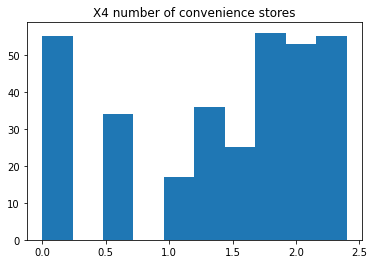

In [78]:
plt.hist(X_train['X4 number of convenience stores'])
plt.title('X4 number of convenience stores')

In [79]:
X_train['X1 transaction date'] = np.log1p(X_train['X1 transaction date'])
X_test['X1 transaction date'] = np.log1p(X_test['X1 transaction date'])

mdl = LinearRegression().fit(X_train, y_train)

train_predictions = mdl.predict(X_train)
test_predictions = mdl.predict(X_test)

print('Помилка на навчальному наборі: ', mean_squared_error(y_train, train_predictions))
print('Помилка на тестовому наборі: ', mean_squared_error(y_test, test_predictions))

Помилка на навчальному наборі:  78.43610464138904
Помилка на тестовому наборі:  53.81127112824963


&emsp;&emsp;Фінально, можна залишити кількість магазинів у форматі логарифму, при цьому рік транзакції після перетворення майже ніяк не вплинув на результат моделі.

&emsp;&emsp;Логорифмування варто спробувати застосувати і до цільової змінної. При цьому варто не забувати застосовувати зворотне перетворення до прогнозів:

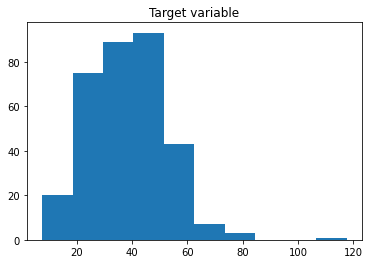

In [80]:
plt.hist(y_train)
plt.title('Target variable')
plt.show()

In [81]:
np.exp(np.log(2))

2.0

In [82]:
log_y_train = np.log(y_train)

mdl = LinearRegression().fit(X_train, log_y_train)

train_predictions = np.exp(mdl.predict(X_train))  # беремо експоненту як зворотне перетворення до логарифму
test_predictions = np.exp(mdl.predict(X_test))

print('Помилка на навчальному наборі: ', mean_squared_error(y_train, train_predictions))
print('Помилка на тестовому наборі: ', mean_squared_error(y_test, test_predictions))

Помилка на навчальному наборі:  88.06539253830377
Помилка на тестовому наборі:  71.26289140300945


&emsp;&emsp;У нашому випадку це перетворення не допомогло і помилка тільки зросла. Тому застосуватиме його надалі не будемо.

&emsp;&emsp;Наступний трюк - поділ змінної. Судячи з наших даних, можна припустити, що до певного моменту вік будинку впливає на ціну негативно, але після тенденція змінюється:

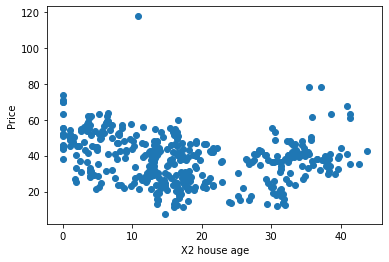

In [83]:
plt.scatter(X['X2 house age'], y)
plt.xlabel('X2 house age')
plt.ylabel('Price')
plt.show()

&emsp;&emsp;При чому настає цей момент при віці близько 33 років. Створимо 2 нові змінні: одна набуває значення віку, якщо вік не більше 33 та 0, якщо вік більше 33, а інша навпаки:

In [84]:
age_threshold = 33

X_train['LowAge'] = np.where(X_train['X2 house age'] <= age_threshold, X_train['X2 house age'], 0)
X_train['HighAge'] = np.where(X_train['X2 house age'] > age_threshold, X_train['X2 house age'], 0)
X_test['LowAge'] = np.where(X_test['X2 house age'] <= age_threshold, X_test['X2 house age'], 0)
X_test['HighAge'] = np.where(X_test['X2 house age'] > age_threshold, X_test['X2 house age'], 0)

mdl = LinearRegression().fit(X_train, y_train)

train_predictions = mdl.predict(X_train)
test_predictions = mdl.predict(X_test)

print('Помилка на навчальному наборі: ', mean_squared_error(y_train, train_predictions))
print('Помилка на тестовому наборі: ', mean_squared_error(y_test, test_predictions))

Помилка на навчальному наборі:  74.71641917730415
Помилка на тестовому наборі:  46.757105575494236


&emsp;&emsp;Помилка значно знизилася. Подивимося на отримані коефіцієнти:

In [14]:
for var_name, coef_value in zip(X_train.columns, mdl.coef_):
    print(var_name, ': ', coef_value)
    
print('constant term: ', mdl.intercept_)

X2 house age :  -0.18755006658272785
X3 distance to the nearest MRT station :  -7.430400536775403
X4 number of convenience stores :  2.338226073866826
X1 transaction date :  14208.51521695304
LowAge :  -0.2046401041918287
HighAge :  0.017090144968608716
constant term:  -108009.5596020216


&emsp;&emsp;Тепер, як і очікувалося, при змінній "LowAge" стоїть від'ємний коефіцієнт, що означає, що при зростанні віку до певного порога ціна на нерухомість падає. Коефіцієнт при "HighAge" говорить про інше.

&emsp;&emsp;Зверніть увагу, що сума коефіцієнтів при "LowAge" та "HighAge" приблизно дорівнює коефіцієнту при "X2 house age". Це тому, що змінні перебувають у лінійної залежності (сума 2х дорівнює 3-ї). Ситуація прямої залежності практично майже не виникає, проте часто можна зустріти дані, в яких деякі змінні дуже сильно корелюють один з одною. Такий ефект називається мультиколлінеарністю і зазвичай призводить до нестабільності моделі. У нашому випадку змінної "X2 house age" краще позбутися як зайвої.

In [85]:
X_train.drop('X2 house age', axis=1, inplace=True)
X_test.drop('X2 house age', axis=1, inplace=True)

mdl = LinearRegression().fit(X_train, y_train)

train_predictions = mdl.predict(X_train)
test_predictions = mdl.predict(X_test)

print('Помилка на навчальному наборі: ', mean_squared_error(y_train, train_predictions))
print('Помилка на тестовому наборі: ', mean_squared_error(y_test, test_predictions))

Помилка на навчальному наборі:  74.71641917729403
Помилка на тестовому наборі:  46.75710557551884


&emsp;&emsp;Видалення зайвої змінної практично не змінило помилку моделі

# Робота з дискретними змінними

&emsp;&emsp;Дискретна (факторна, категоріальна) змінна - це така, яка набуває значення на зліченній (як правило скінченній) множині значень. Прикладом такої змінної може бути клас каюти або стать пасажира в даних про Титанік:

In [86]:
data = pd.read_csv('TitanicDataset.csv', sep=',', header=0)
print('можливі значення класу каюти: ', data['Pclass'].unique())
print('можливі значення статі пасажира: ', data['Sex'].unique())

можливі значення класу каюти:  [3 1 2]
можливі значення статі пасажира:  ['male' 'female']


&emsp;&emsp;Приклади роботи з дискретними змінними розбиратимемо при побудові моделі передбачення ймовірності виживання на Титаніку. Для цього виберемо деякі змінні з наявних даних і розіб'єм їх на навчальну та тестову вибірку:

In [88]:
# виберемо кілька змінних з наявних + цільову; при цьому проігноруємо рядки, в яких вік невідомий
X = data[['Sex', 'Age', 'Fare', 'Pclass']][~data['Age'].isna()].copy()
y = data['Survived'][~data['Age'].isna()].copy()

# розділимо дані на 2 набори: навчальну та тестову групу
X_train, X_test, y_train, y_test = train_test_split(
    X,  # перший масив, який потрібно розділити
    y,  # другий масив, який потрібно роздолити
    test_size=0.2,  # розмір меншої групи (20% від загальної кількості даних)
    random_state=42  # фіксація випадкового стану: тепер при перезапуску групи будуть однаковими
)

# формальність для того, щоб не бачити попередження про зміни на зрізі з таблиці
X_train, X_test = X_train.copy(), X_test.copy()

&emsp;&emsp;Працювати безпосередньо з катигорними змінними неможливо. Перед введенням у модель необхідно надати їм числове значення.

&emsp;&emsp;У найпростішому випадку, якщо змінна бінарна (приймає лише 2 можливі значення), то зазвичай одному з її значень надають значення 0, а іншому 1. При цьому вибір довільний:

In [89]:
X_train['Sex'] = np.where(X_train['Sex'] == 'male', 1, 0)
X_test['Sex'] = np.where(X_test['Sex'] == 'male', 1, 0)

&emsp;&emsp;Якщо змінна приймає більше двох можливих значень (як у випадку з класом каюти), то її можна представити як n або n-1 бінарних змінних, де n - кількість можливих значень оригінальної змінної:

In [90]:
# представлення змінної у вигляді набору бінарних змінних
ohe = pd.get_dummies(
    X_test['Pclass'],  # значення змінної, яку потрібно перетворити
    prefix='x'  # префікс до назви колонки, яка вийде в результаті
).reset_index(drop=True)

ohe['Pclass'] = X_test['Pclass'].values  # додамо оригінальну змінну до отриманої таблиці для ілюстрації
ohe.head()

,x_1,x_2,x_3,Pclass
0,0,1,0,2
1,0,1,0,2
2,0,1,0,2
3,1,0,0,1
4,0,0,1,3


&emsp;&emsp;Суть отриманих змінних така: х_1 набуває значення 1, якщо оригінальна змінна набуває значення 1 і 0 в іншому випадку; х_2 набуває значення 1, якщо оригінальна змінна набуває значення 2 і 0 в іншому випадку і т.д. Отримані змінні називаються фіктивними (dummie), а перетворення називається one-hot-encoding. 

&emsp;&emsp;Формально, n-я фіктивна змінна є зайвою: знаючи значення n-1 отриманих змінних можна однозначно зрозуміти значення останньої. Однак часто її в моделях залишають через те, що в майбутньому може з'явитися приклад, для якого значення оригінальної змінної таке, якого не було в навчальних даних. У такій ситуації значення 0 для n-1 фіктивних змінних не означає, що n-а змінна прийняла значення 1. У нашому випадку ми впевнені, що інших класів, окрім {1,2,3}, не з'явиться, тому можемо прибрати одну колонку.

In [91]:
# додамо фіктивні змінні на основі класу каюти в навчальні та тестові дані
X_train = pd.concat([X_train, pd.get_dummies(X_train['Pclass'], prefix='class')], axis=1)
X_test = pd.concat([X_test, pd.get_dummies(X_test['Pclass'], prefix='class')], axis=1)

# видалимо оригінальну змінну
X_train.drop('Pclass', axis=1, inplace=True)
X_test.drop('Pclass', axis=1, inplace=True)

In [92]:
X_train.head()

,Sex,Age,Fare,class_1,class_2,class_3
328,0,31.0,20.5250,0,0,1
73,1,26.0,14.4542,0,0,1
253,1,30.0,16.1000,0,0,1
719,1,33.0,7.7750,0,0,1
666,1,25.0,13.0000,0,1,0


&emsp;&emsp;Можемо побудувати модель на отриманих змінних та оцінити її за допомогою AUC:

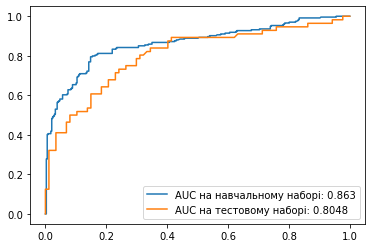

In [93]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc

mdl = LogisticRegression().fit(X_train, y_train)  # оцінимо модель

# отримаємо оцінки ймовірностей для навчального та тестового набору
train_preds, test_preds = mdl.predict_proba(X_train)[:, 1], mdl.predict_proba(X_test)[:, 1]

# отримуємо відсоток хибнопозитивних та хибнонегативних прикладів для різних порогових значень
train_fpr, train_tpr, _ = roc_curve(y_train, train_preds)
test_fpr, test_tpr, _ = roc_curve(y_test, test_preds)

# обчислимо значення AUC для навчального та тестового наборів
train_auc, test_auc = np.round(auc(train_fpr, train_tpr), 4), np.round(auc(test_fpr, test_tpr), 4)

# побудуємо графік RUC кривою для обох наборів даних
plt.plot(train_fpr, train_tpr, label=f'AUC на навчальному наборі: {train_auc}')
plt.plot(test_fpr, test_tpr, label=f'AUC на тестовому наборі: {test_auc}')
plt.legend()  # додамо легенду, щоб відобразилися значення параметрів "label" у кожному графіку
plt.show()

&emsp;&emsp;Проведемо аналіз отриманих коефіцієнтів моделі:

In [94]:
for var_name, coef_value in zip(X_train.columns, mdl.coef_[0]):
    print(var_name, ': ', coef_value)

Sex :  -2.5272433640557934
Age :  -0.04271363933958991
Fare :  -0.00016233920019599583
class_1 :  1.3216964605906438
class_2 :  -0.14942199307154733
class_3 :  -1.1722825463348536


&emsp;&emsp;З результатів видно, що ймовірність виживання тим більше, чим вищий клас каюти. Негативний коефіцієнт за вартістю квитка, швидше за все, пов'язаний з тим, що цей ефект вже пояснений класом каюти.

&emsp;&emsp;Як зазнечалося вище, у нашому випадку, одна із змінних відповідальних за клас каюти є зайвою. Спробуємо її прибрати:

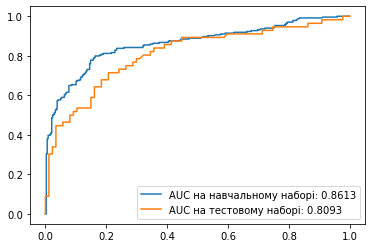

In [95]:
X_train.drop('class_1', axis=1, inplace=True)
X_test.drop('class_1', axis=1, inplace=True)

mdl = LogisticRegression().fit(X_train, y_train)  # оцінемо модель

# отримаємо оцінки ймовірностей для навчального та тестового набору
train_preds, test_preds = mdl.predict_proba(X_train)[:, 1], mdl.predict_proba(X_test)[:, 1]

# отримуємо відсоток хибнопозитивних та хибнонегативних прикладів для різних порогових значень
train_fpr, train_tpr, _ = roc_curve(y_train, train_preds)
test_fpr, test_tpr, _ = roc_curve(y_test, test_preds)

# обчислимо значення AUC для навчального та тестового наборів
train_auc, test_auc = np.round(auc(train_fpr, train_tpr), 4), np.round(auc(test_fpr, test_tpr), 4)

# побудуємо графік RUC кривою для обох наборів даних
plt.plot(train_fpr, train_tpr, label=f'AUC на навчальному наборі: {train_auc}')
plt.plot(test_fpr, test_tpr, label=f'AUC на тестовому наборі: {test_auc}')
plt.legend()  # додамо легенду, щоб відобразилися значення параметрів "label" у кожному графіку
plt.show()

&emsp;&emsp;Як і очікувалося, модель не втратила якості і навіть стала трохи кращою. При повторному аналізі коефіцієнтів видно, що змінна Fare отримала назад свій додатний коефіцієнт:

In [96]:
for var_name, coef_value in zip(X_train.columns, mdl.coef_[0]):
    print(var_name, ': ', coef_value)

Sex :  -2.4939526693951395
Age :  -0.03979903736667623
Fare :  0.0010232048771130395
class_2 :  -1.2252660604377443
class_3 :  -2.2374548715223894


&emsp;&emsp;На практиці ми не можемо бути впевнені, що множина можливих значень дискретної змінної в нашому тестовому наборі така ж, як і в навчальному, не кажучи вже про ті дані, яких ми взагалі не бачили.

&emsp;&emsp;Наприклад:

In [99]:
x_known = np.random.choice(['apple', 'orange', 'banana', 'onion'], size=100, replace=True)
x_new = np.random.choice(['apple', 'orange', 'banana'], size=100, replace=True)

In [100]:
x_known

array(['orange', 'orange', 'orange', 'banana', 'apple', 'banana', 'apple',
       'banana', 'banana', 'onion', 'banana', 'onion', 'orange', 'orange',
       'banana', 'banana', 'banana', 'banana', 'orange', 'apple', 'apple',
       'apple', 'orange', 'banana', 'apple', 'banana', 'orange', 'onion',
       'apple', 'onion', 'onion', 'orange', 'onion', 'apple', 'apple',
       'apple', 'orange', 'banana', 'apple', 'orange', 'apple', 'orange',
       'banana', 'onion', 'banana', 'banana', 'banana', 'apple', 'banana',
       'onion', 'apple', 'banana', 'onion', 'apple', 'apple', 'orange',
       'onion', 'apple', 'apple', 'apple', 'onion', 'orange', 'orange',
       'orange', 'onion', 'apple', 'orange', 'banana', 'banana', 'banana',
       'apple', 'onion', 'banana', 'apple', 'banana', 'orange', 'orange',
       'banana', 'onion', 'apple', 'banana', 'onion', 'orange', 'apple',
       'orange', 'onion', 'orange', 'onion', 'banana', 'banana', 'apple',
       'apple', 'banana', 'apple', 'apple

In [101]:
x_known = pd.get_dummies(x_known, prefix='x')
x_new = pd.get_dummies(x_new, prefix='x')

In [102]:
x_known.head()

,x_apple,x_banana,x_onion,x_orange
0,0,0,0,1
1,0,0,0,1
2,0,0,0,1
3,0,1,0,0
4,1,0,0,0


In [103]:
x_new.head()

,x_apple,x_banana,x_orange
0,0,0,1
1,0,0,1
2,0,1,0
3,0,0,1
4,1,0,0


&emsp;&emsp;Спроба передати моделі дані, в яких менше або більше змінних, ніж вона очікує, в більшості випадків призведе до помилки. Щоб цього уникнути необхідно запам'ятати який був набір значень на навчальному наборі і простежити, щоб на тестовому був такий самий. Зручно цього досягти дозволяє бібліотека для роботи з категоріальними змінними "category_encoders":

In [104]:
# pip install category_encoders

In [105]:
import category_encoders as ce

# створимо ті ж дані
x_known = np.random.choice(['apple', 'orange', 'banana', 'onion'], size=100, replace=True)
x_new = np.random.choice(['apple', 'orange', 'banana'], size=100, replace=True)

# приведемо дані до формату DataFrame (category_encoders очікує на вході цей формат)
x_known = pd.DataFrame(x_known, columns=['x'])
x_new = pd.DataFrame(x_new, columns=['x'])

# навчимо модель кодувальника на навчальних даних
encoder = ce.OneHotEncoder(
    cols=['x'],  # список колонок, які потрібно привести до формату фіктивних змінних
    use_cat_names=True  # чи включити імена значень змінної до назв отриманих змінних
).fit(x_known)

# тепер можемо користуватися нашим кодувальником для будь-якого іншого набору даних
x_known_encoded = encoder.transform(x_known)
x_new_encoded = encoder.transform(x_new)

D:\Anaconda3\lib\site-packages\category_encoders\one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():


In [106]:
x_known_encoded.head()

,x_orange,x_banana,x_apple,x_onion
0,1,0,0,0
1,0,1,0,0
2,0,0,1,0
3,0,0,0,1
4,0,1,0,0


In [107]:
x_new_encoded.head()

,x_orange,x_banana,x_apple,x_onion
0,0,0,1,0
1,0,0,1,0
2,0,0,1,0
3,0,1,0,0
4,0,1,0,0


&emsp;&emsp;У такій імплементації ми гарантовано отримаємо ті колонки, які були присутні на етапі навчання моделі. У прикладі вище колонка "x_onion" завжди міститиме значення 0, оскільки "onion" ніколи не зустрічається в цьому наборі даних.

&emsp;&emsp;Проблеми з представленням у вигляді набору бінарних змінних полягає в тому, що якщо множина можливих значень оригінальної змінної досить велика, то і кількість фіктивних змінних буде дуже великою. Зокрема, воно може перевищувати кількість спостережень у даних, що унеможливлює побудову моделі.

&emsp;&emsp;Другий популярний спосіб передставлення змінної, який не призведе до збільшення числа змінних у моделі, - це кодування цільової змінної (target encoding). Ідея полягає в тому, щоб запам'ятати яке середнє значення залежної змінної було при кожному можливому значенні факторної змінної, а потім замінити його на це середнє.

&emsp;&emsp;Приклад:

In [108]:
data['PclassEncoded'] = data.groupby('Pclass')['Survived'].transform(np.mean)

data[['Pclass', 'PclassEncoded']].head(10)

,Pclass,PclassEncoded
0,3,0.242363
1,1,0.629630
2,3,0.242363
3,1,0.629630
4,3,0.242363
5,3,0.242363
6,1,0.629630
7,3,0.242363
8,3,0.242363
9,2,0.472826


&emsp;&emsp;Середня ймовірність виживання в 3-му класі приблизно 24%, тому коли значення змінної дорівнює 3, то ми замінимо його на 0.24, для першого класу - на 0.63 і т.д. Таким чином, ми отримаємо неперервну змінну, яку можна помістити в модель.

&emsp;&emsp;При такому підході потрібно бути особливо акуратним і слідкувати за такими речами:

&emsp;&emsp;1. Якщо ви тестуєте модель на окремому наборі даних, то не можна допускати, щоб значення цільової змінної тестового набору було враховано при розрахунку середніх. Така ситуація називається витоком (target leackage) та призведе до того, що результат на тесті буде менш показовим.

&emsp;&emsp;2. Часто виникає ситуація, коли деякі значення змінної трапляються досить рідко (скажімо, менше 1% випадків). Тоді спроба оцінити середнє для цих значень може призвести до результату рівно 0 або 1 через те, що ми не спостерігали жодного позитивного або негативного результату таких значень. Така оцінка дуже ненадійна і найчастіше пов'язана з нестачею навчальних прикладів. У такій ситуації слід об'єднати рідкісні значення в новий клас "інше" або скористатися середнім значенням змінної на всіх даних замість значення для конкретного класу. Як варіант можна запропонувати таку процедуру згладжування:

$$value = alpha \cdot avg(y | class) + (1 - alpha) \cdot avg(y)$$

&emsp;&emsp;avg(y|class) - середнє значення цільової змінної для даного значення факторної змінної,

&emsp;&emsp;avg(y) - середнє значення цільової змінної,

&emsp;&emsp;alpha - параметр згладжування (перебуває в інтервалі між 0 і 1). Цей параметр визначає, наскільки ми можемо довіряти середньому значенню для кожної категорії окремо. Значення 0 дасть заміну на глобальне середнє, тоді як 1 означатиме, що ми вважаємо середні рівні серединім кожної категорії, як у прикладі вище.

&emsp;&emsp;Приклад:

In [109]:
data['GlobalAverage'] = np.mean(data['Survived'])
alpha = 0.7
data['PclassEncoded_w_Smoothing'] = alpha * data['PclassEncoded'] + (1 - alpha) * data['GlobalAverage']

data[['Pclass', 'PclassEncoded', 'GlobalAverage', 'PclassEncoded_w_Smoothing']].head(10)

,Pclass,PclassEncoded,GlobalAverage,PclassEncoded_w_Smoothing
0,3,0.242363,0.383838,0.284805
1,1,0.629630,0.383838,0.555892
2,3,0.242363,0.383838,0.284805
3,1,0.629630,0.383838,0.555892
4,3,0.242363,0.383838,0.284805
5,3,0.242363,0.383838,0.284805
6,1,0.629630,0.383838,0.555892
7,3,0.242363,0.383838,0.284805
8,3,0.242363,0.383838,0.284805
9,2,0.472826,0.383838,0.446130


&emsp;&emsp;Таким чином ми отримали більш надійні оцінки для кожної категорії класу каюти, при цьому все ще підкреслюють, що різниця у ймовірності виживання є.

&emsp;&emsp;На практиці краще скористатися класом з тієї ж бібліотеки "category_encoders":

In [113]:
# замінимо тип змінної на рядок,
# оскільки функції category_encoders бібліотеки трансформують лише рядкові змінні
data['Pclass'] = data['Pclass'].astype(str)

# створимо об'єкт кодувальника
encoder = ce.TargetEncoder(
    min_samples_leaf=10, # якщо прикладів у категорії менше 10, то заміна буде зроблена на загальну середню
    smoothing=30 # параметр згладжування: чим більше, тим ближче до глобального середнього будуть виходити значення
)

# тепер кодувальник потрібно навчити використовуючи значення цільової змінної
encoder = encoder.fit(data['Pclass'], data['Survived'])

# додамо нову змінну закодувавши Pclass
data['PclassEncoded_w_Smoothing_external'] = encoder.transform(data['Pclass'])

data[['Pclass', 'PclassEncoded', 'PclassEncoded_w_Smoothing', 'PclassEncoded_w_Smoothing_external']].head()

,Pclass,PclassEncoded,PclassEncoded_w_Smoothing,PclassEncoded_w_Smoothing_external
0,3,0.242363,0.284805,0.242363
1,1,0.629630,0.555892,0.629374
2,3,0.242363,0.284805,0.242363
3,1,0.629630,0.555892,0.629374
4,3,0.242363,0.284805,0.242363


&emsp;&emsp;Отримана колонка за значенням набагато ближче до 'PclassEncoded', ніж до нашої попередньої 'PclassEncoded_w_Smoothing'. Це тому, що параметр 'smoothing' працює дещо інакше, як наше згладжування за допомогою 'alpha'. У процесі розрахунку середніх береться до уваги скільки було спостережень для кожного значення категорії. Оскільки у кожному класі у нас є сотні пасажирів, тобто всі підстави "довіряти" середньому всередині кожного класу і немає причин робити сильне усереднення із глобальним середнім.

&emsp;&emsp;Спробуємо замінити наші фіктивні змінні моделі для Титаніка на target encoding

In [114]:
# розділи дані знову, тому що раніше ми вже видалили оригінальну змінну "Pclass"
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test = X_train.copy(), X_test.copy()
X_train['Pclass'], X_test['Pclass'] = X_train['Pclass'].astype(str), X_test['Pclass'].astype(str)
X_train['Sex'], X_test['Sex'] = np.where(X_train['Sex'] == 'male', 1, 0), np.where(X_test['Sex'] == 'male', 1, 0)

# навчимо кодувальник тільки на навчальному наборі
encoder = ce.TargetEncoder(min_samples_leaf=10, smoothing=30).fit(X_train['Pclass'], y_train)

# замінимо змінну Pclass в навчальному та тестовому наборі
X_train['PclassEnc'] = encoder.transform(X_train['Pclass'])
X_test['PclassEnc'] = encoder.transform(X_test['Pclass'])
X_train.head()

,Sex,Age,Fare,Pclass,PclassEnc
328,0,31.0,20.5250,3,0.259013
73,1,26.0,14.4542,3,0.259013
253,1,30.0,16.1000,3,0.259013
719,1,33.0,7.7750,3,0.259013
666,1,25.0,13.0000,2,0.443251


&emsp;&emsp;Зверніть увагу, що значення PclassEnc відрізняються від тих, що ми отримували вище через те, що ми скористалися лише навчальними даними, щоб уникнути витоку.

&emsp;&emsp;Тепер нам залишилося лише видалити оригінальну змінну та навчити модель:

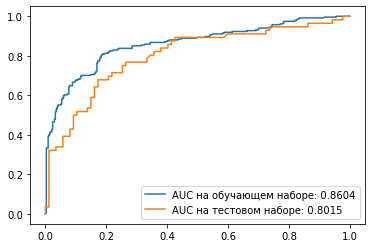

In [37]:
X_train.drop('Pclass', axis=1, inplace=True)
X_test.drop('Pclass', axis=1, inplace=True)

mdl = LogisticRegression().fit(X_train, y_train)  # оцінимо модель

# отримаємо оцінки ймовірностей для навчального та тестового набору
train_preds, test_preds = mdl.predict_proba(X_train)[:, 1], mdl.predict_proba(X_test)[:, 1]

# отримуємо відсоток хибнопозитивних та хибнонегативних прикладів для різних порогових значень
train_fpr, train_tpr, _ = roc_curve(y_train, train_preds)
test_fpr, test_tpr, _ = roc_curve(y_test, test_preds)

# обчислимо значення AUC для навчального та тестового наборів
train_auc, test_auc = np.round(auc(train_fpr, train_tpr), 4), np.round(auc(test_fpr, test_tpr), 4)

# побудуємо графік RUC кривою для обох наборів даних
plt.plot(train_fpr, train_tpr, label=f'AUC на обучающем наборе: {train_auc}')
plt.plot(test_fpr, test_tpr, label=f'AUC на тестовом наборе: {test_auc}')
plt.legend()  # додамо легенду, щоб відобразилися значення параметрів "label" у кожному графіку
plt.show()

&emsp;&emsp;Результат вийшов дуже схожим, але трохи гіршим у сенсі значення AUC. Тобто в даному випадку краще залишитися з факторними змінними.

# Важливість змінних

&emsp;&emsp;Коли модель побудована природно виникає питання, які змінні є більш важливими для прийняття рішення. Для різних моделей є різні способи визначити важливість, однак є один підхід, який дозволяє працювати з усіма моделями.

&emsp;&emsp;Ідея наступна: чим більша важливість змінної, тим більше впаде точність моделі, якщо цю змінну прибрати і навпаки. Тобто можна запропонувати наступний алгоритм:

&emsp;&emsp;1. Навчити модель на якомусь наборі змінних та обчислити точність

&emsp;&emsp;2. Замінити одну змінну на випадковий шум (на практиці зручно просто перемішати значення оригінальної змінної)

&emsp;&emsp;3. Обчислити нову точність та порівняти наскільки вона впала порівняно з початковою

&emsp;&emsp;4. Вивести значимість змінної пропорційно до зміни точності

AUC оригінальної моделі:  0.8015188834154352


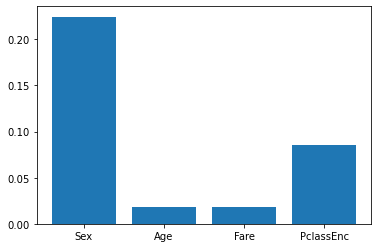

In [38]:
from sklearn.metrics import roc_auc_score

# обчислимо значення AUC для моделі без змін
original_auc = roc_auc_score(y_test, mdl.predict_proba(X_test)[:, 1])
print('AUC оригінальної моделі: ', original_auc)

# оскільки перемішування процедура випадкова, то зафіксуємо випадковий стан
np.random.seed(21)

# пройдемося по кожній змінній, перемішаємо її та отримаємо новий AUC
diffs = []  # ініціалізуємо порожній список, до якого будемо класти значення змін AUC
for var in X_test.columns:    
    X_test_upd = X_test.copy()  # зробимо копію тестових даних, щоб не вносити зміни до оригінальної таблиці
    X_test_upd[var] = np.random.permutation(X_test_upd[var].values)  # переставимо значення місцями
    new_auc = roc_auc_score(y_test, mdl.predict_proba(X_test_upd)[:, 1])  # отримаємо нове значення AUC
    diff = abs(new_auc - original_auc) / original_auc  # обчислимо відносне відхилення
    diffs.append(diff)
    
# побудуємо графік важливості змінних
plt.bar(X_test.columns, diffs)
plt.show()

&emsp;&emsp; Той самий результат можна отримати і за допомогою готової функції зі sklearn.inspection

In [39]:
from sklearn.inspection import permutation_importance

importances = permutation_importance(
    mdl, X_test, y_test,  # модель та дані, на яких оцінювати важливість
    n_repeats=10,  # скільки разів повторити перемішування та оцінку важливості
    random_state=42  # фіксація випадкового стану
)

for i, column in enumerate(X_test.columns):    
    # вивести на екран ім'я змінної, середнє значення та стандартне відхилення важливості змінної
    print(column, importances.importances_mean[i], importances.importances_std[i])

Sex 0.2062937062937063 0.03650456821297394
Age 0.0013986013986013956 0.013559943657108584
Fare 0.011188811188811165 0.006409196776162001
PclassEnc 0.03216783216783211 0.008391608391608397


&emsp;&emsp;Як бачимо найважливішою змінною є стать пасажира. На другому місці – ціна каюти. Змінні вік та клас каюти практично неважливі і можемо спробувати прибрати їх із моделі:

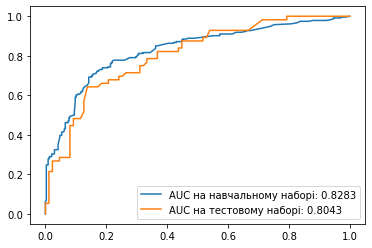

In [40]:
X_train.drop(['Age', 'PclassEnc'], axis=1, inplace=True)
X_test.drop(['Age', 'PclassEnc'], axis=1, inplace=True)

mdl = LogisticRegression().fit(X_train, y_train)  # оцінимо модель

# отримаємо оцінки ймовірностей для навчального та тестового набору
train_preds, test_preds = mdl.predict_proba(X_train)[:, 1], mdl.predict_proba(X_test)[:, 1]

# отримуємо відсоток хибнопозитивних та хибнонегативних прикладів для різних порогових значень
train_fpr, train_tpr, _ = roc_curve(y_train, train_preds)
test_fpr, test_tpr, _ = roc_curve(y_test, test_preds)

# обчислимо значення AUC для навчального та тестового наборів
train_auc, test_auc = np.round(auc(train_fpr, train_tpr), 4), np.round(auc(test_fpr, test_tpr), 4)

# побудуємо графік RUC кривою для обох наборів даних
plt.plot(train_fpr, train_tpr, label=f'AUC на навчальному наборі: {train_auc}')
plt.plot(test_fpr, test_tpr, label=f'AUC на тестовому наборі: {test_auc}')
plt.legend()  # додамо легенду, щоб відобразилися значення параметрів "label" у кожному графіку
plt.show()

&emsp;&emsp;Як і очікувалося, прибравши зайві змінні модель не втратила якості і навіть трохи покращила точність на тестовому наборі. У загальному випадку погані змінні завжди варто виключати з моделі.

&emsp;&emsp;Слід зазначити, що процедура перемішування значень змінної, якою ми скористалися вище, є випадковою. Для більш надійних результатів можна повторити її кілька разів і усереднити отримані оцінки важливості.

# Робота з відсутніми значеннями

&emsp;&emsp;Жодна модель не може бути побудована на даних, що містять відсутні в значеннях. Ті алгоритми, які дозволяють це просто неявно замінюють відсутніі значення за якимось своїм вбудованим правилам.
Існують такі основні підходи до роботи з відсутніми значень:

&emsp;&emsp;1. Якщо відсутніх значень дуже багато, а сама змінна не дуже важлива, то перший і найпростіший варіант, який варто розглянути – це видалити саму змінну. Так, наприклад, у даних про Титаніку, знання про номер каюти пасажира не має значення для моделі виживання, але при цьому містить відсутні значення. Відповідно, тут цю змінну краще видалити.

&emsp;&emsp;2. Для дискретних змінних найчастіше відсутні значення відправляють у додатковий клас 'unknown' і продовжують працювати зі змінною, якби вона могла прийняти одне додаткове значення.

&emsp;&emsp;Приклад:

In [41]:
# створимо копію даних Титаніка і видалимо деякі значення зі змінної 'Pclass'
dt = data.copy()
dt.loc[np.random.choice(dt.index, size=100, replace=False), 'Pclass'] = np.nan
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 16 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   PassengerId                         891 non-null    int64  
 1   Survived                            891 non-null    int64  
 2   Pclass                              791 non-null    object 
 3   Name                                891 non-null    object 
 4   Sex                                 891 non-null    object 
 5   Age                                 714 non-null    float64
 6   SibSp                               891 non-null    int64  
 7   Parch                               891 non-null    int64  
 8   Ticket                              891 non-null    object 
 9   Fare                                891 non-null    float64
 10  Cabin                               204 non-null    object 
 11  Embarked                            889 non-n

&emsp;&emsp;Як бачимо 100 значень змінної 'Pclass' тепер містять значення null. Заповнимо їх новим фіктивним класом і навчимо кодувальник:

In [42]:
dt['PclassFilled'] = dt['Pclass']
dt['PclassFilled'].fillna('unknown', inplace=True)

encoder = ce.TargetEncoder(min_samples_leaf=10, smoothing=30).fit(dt['PclassFilled'], dt['Survived'])
dt['PclassEncoded'] = encoder.transform(dt['PclassFilled'])

dt[['PclassFilled', 'PclassEncoded']][dt['Pclass'].isna()].head()

,PclassFilled,PclassEncoded
23,unknown,0.380182
24,unknown,0.380182
29,unknown,0.380182
33,unknown,0.380182
35,unknown,0.380182


&emsp;&emsp;3. Для неперервної змінної найпростішим і найпопулярнішим рішенням є заміна відсутніх значень на середнє або медіанне значення самої змінної.

&emsp;&emsp;Приклад:

In [43]:
median_fill = np.median(dt['Age'][~dt['Age'].isna()])
dt['AgeFilled'] = dt['Age'].fillna(median_fill, inplace=False)
dt[['Age', 'AgeFilled']][dt['Age'].isna()].head()

,Age,AgeFilled
5,NaN,28.0
17,NaN,28.0
19,NaN,28.0
26,NaN,28.0
28,NaN,28.0


&emsp;&emsp;4. Якщо є причини вважати, що пропущені значення в неперервній змінній несуть якусь інформацію, то краще додати одну додаткову бінарну змінну, яка приймає значення 1, де оригінальна змінна містила пропуски і 0 в іншому випадку. Прикладом такої ситуації може бути соціологічне опитування, в якому відсутнє значення означає відмову відповідати на будь-яке питання, що може бути натяком на відповідь. Самі ж відсутні значенн замінюють у такому разі на 0:

In [44]:
dt['AgeFilled'] = np.where(dt['Age'].isna(), 0, dt['Age'])
dt['IsUnknownAge'] = np.where(dt['Age'].isna(), 1, 0)
dt[['Age', 'AgeFilled', 'IsUnknownAge']][dt['Age'].isna()].head()

,Age,AgeFilled,IsUnknownAge
5,NaN,0.0,1
17,NaN,0.0,1
19,NaN,0.0,1
26,NaN,0.0,1
28,NaN,0.0,1


&emsp;&emsp;5. Найскладнішим способом, що вимагає додаткового аналізу, є заміна на основі значень інших змінних. Наприклад, якби в нас були відсутні значення вартості квитка, то можна було б на підставі класу каюти та місця посадки зробити непогану здогад щодо невідомої вартості:

In [45]:
# видалимо деякі значення з колонки, що містить вартість квитка
dt = data.copy()
dt['FareWithNulls'] = dt['Fare']
dt.loc[np.random.choice(dt.index, size=100, replace=False), 'FareWithNulls'] = np.nan
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 17 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   PassengerId                         891 non-null    int64  
 1   Survived                            891 non-null    int64  
 2   Pclass                              891 non-null    object 
 3   Name                                891 non-null    object 
 4   Sex                                 891 non-null    object 
 5   Age                                 714 non-null    float64
 6   SibSp                               891 non-null    int64  
 7   Parch                               891 non-null    int64  
 8   Ticket                              891 non-null    object 
 9   Fare                                891 non-null    float64
 10  Cabin                               204 non-null    object 
 11  Embarked                            889 non-n

In [46]:
dt['FareGuess'] = dt[~dt['Fare'].isna()].groupby(['Pclass', 'Embarked'])['Fare'].transform(np.median)
dt[['FareWithNulls', 'Fare', 'FareGuess']][dt['FareWithNulls'].isna()].head(15)

,FareWithNulls,Fare,FareGuess
2,NaN,7.9250,8.0500
19,NaN,7.2250,7.8958
44,NaN,7.8792,7.7500
51,NaN,7.8000,8.0500
63,NaN,27.9000,8.0500
65,NaN,15.2458,7.8958
68,NaN,7.9250,8.0500
84,NaN,10.5000,13.5000
88,NaN,263.0000,52.0000
97,NaN,63.3583,78.2667


# Викиди (outliers)

&emsp;&emsp;Часто в навчальному наборі є спостереження, які дуже сильно вибиваються з шаблону і модель робить дуже великі помилки для них навіть на етапі навчання. Такі спостереження часто негативно впливають на навчання моделі і їх краще позбутися. Інтуїтивно можна зрозуміти це так: є приклади, для яких ми все одно не можемо дати хороший прогноз - варто їх прибрати, щоб допомогти моделі зосередитися на типових випадках.

&emsp;&emsp;Для прикладу повернемося до даних про вартість житла:

In [47]:
data = pd.read_csv('RealEstate.csv', sep=',', header=0)

X = data[['X2 house age', 'X3 distance to the nearest MRT station',
          'X4 number of convenience stores', 'X1 transaction date']]

y = data['Y house price of unit area'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)
X_train, X_test = X_train.copy(), X_test.copy()

mdl = LinearRegression().fit(X_train, y_train)

train_predictions = mdl.predict(X_train)
test_predictions = mdl.predict(X_test)

print('Помилка на навчальному наборі: ', mean_squared_error(y_train, train_predictions))
print('Помилка на тестовому наборі: ', mean_squared_error(y_test, test_predictions))

Помилка на навчальному наборі:  88.38446412672515
Помилка на тестовому наборі:  58.06687255049843


&emsp;&emsp;Зазвичай точки, які вибиваються із загальної тенденції, добре видно на графіку фактичних та прогнозних значень:

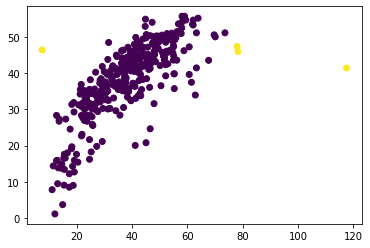

In [48]:
train_errors = np.abs(y_train - train_predictions) # порахуємо помилку як абсолютне відхилення від прогнозу
percentile99 = np.percentile(train_errors, 99) # знайдемо значення, менше якого знаходиться 99% помилок
is_big_error = np.where(train_errors > percentile99, 1, 0) # відзначимо точки, для яких помилка потрапляє в топ 1%

# побудуємо графік фактичних значень проти прогнозних
plt.scatter(
     y_train,
     train_predictions,
     c=is_big_error # колір точки залежить від ступеня помилки
)

plt.show()

&emsp;&emsp;Як видно на малюнку, точки, що позначені жовтим дуже сильно вибиваються із шаблону. Спробуємо видалити їх на етапі навчання моделі:

In [49]:
inline_mask = train_errors <= percentile99
X_train, y_train = X_train[inline_mask], y_train[inline_mask]

mdl = LinearRegression().fit(X_train, y_train)

train_predictions = mdl.predict(X_train)
test_predictions = mdl.predict(X_test)

print('Помилка на навчальному наборі: ', mean_squared_error(y_train, train_predictions))
print('Помилка на тестовому наборі: ', mean_squared_error(y_test, test_predictions))

Помилка на навчальному наборі:  60.854963687766904
Помилка на тестовому наборі:  56.9208099918635


&emsp;&emsp;Як бачимо, помилка зменшилася як на навчальному, так і на тестовому наборі. В інших ситуаціях може бути більш відповідним видалити не топ 1%, а більше або не видаляти зовсім. Рішення, як завжди, варто приймати на основі зміни помилки тестового набору.

# Зважування спостережень

&emsp;&emsp;Часто виникають ситуації, в яких коректні прогнози для одних спостережень важливіші, ніж для інших. Прикладом може бути модель для розпізнавання шахрайської активності, де правильно виявити одного шахрая більш критично, ніж сказати про 10 звичайних користувачів, що з ними все гаразд.

&emsp;&emsp;Якщо узагальнити, це правильно майже всім незбалансованих наборів даних - таких, котрим той чи інший клас цільової змінної представлений набагато рідше, ніж інші. Трапляється, що модель бачить сотні негативних прикладів та одиниці позитивних, що може негативно позначитися на розпізнаванні останніх у майбутньому.

&emsp;&emsp;Зважування спостережень - це спосіб акцентувати увагу моделі на цікавих для нас прикладах. Наприклад розглянемо функцію втрат для логістичної регресії:

$$loss = -\frac {1} {n}\sum_{i = 1}^{n}\Big(y_{i}ln(p_{i}) + (1 - y_{i})ln(1 - p_{i})\Big)$$

&emsp;&emsp;У такому формулюванні кожне спостереження моделі рівноважно: помилившись однаково на першому і другому прикладі внесок у загальну помилку (loss) буде однаковим. Переформулюємо функцію так:

$$loss = -\frac {1} {\sum_{i = 1}^{n}{w_{i}}}\sum_{i = 1}^{n}{w_{i}\Big(y_{i}ln(p_{i}) + (1 - y_{i})ln(1 - p_{i})\Big)}$$

&emsp;&emsp;Тут $w_i$ - це вага, яка присвоєна кожному спостереженню окремо. Тепер, при однаковій помилці на першому і другому прикладі їх внесок у загальну функцію втрат буде різним: $w_1$ і $w_2$, відповідно. Таким чином, якщо $w_2$ більше, ніж $w_1$, то для зниження загальної втрати моделі доведеться більше сконцентруватися на другому прикладі, ніж на першому.

&emsp;&emsp;Для прикладу скористаємося даними про шахрайські дії з кредитними картками. Вважатимемо, що існує додаткова бізнес вимога, яка говорить: "правильно обчислити одного шахрая в 20 разів важливіше, ніж просто підтвердити для звичайного клієнта, що з ним все ок".

In [50]:
fraud_dt = pd.read_csv('fraud_detection.csv', sep=';', header=0)
fraud_dt.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,10492.000000,10492.000000,10492.000000,10492.000000,10492.000000,10492.000000,10492.000000,10492.000000,10492.000000,10492.000000,...,10492.000000,10492.000000,10492.000000,10492.000000,10492.000000,10492.000000,10492.000000,10492.000000,10492.000000,10492.000000
mean,94587.165841,-0.197476,0.143143,-0.303060,0.203662,-0.139521,-0.059322,-0.258059,0.002513,-0.139406,...,0.040509,-0.001458,0.003243,-0.001884,-0.001850,-0.004254,0.009800,0.003223,90.229797,0.046893
std,47428.184436,2.561736,1.995360,2.567587,1.790170,1.848872,1.382166,2.250852,1.867192,1.302302,...,1.117863,0.780458,0.677584,0.601804,0.535506,0.477080,0.460587,0.357483,234.750558,0.211419
min,10.000000,-35.698345,-37.154221,-31.103685,-4.729482,-22.105532,-12.709475,-43.557242,-41.044261,-13.434066,...,-22.797604,-8.887017,-26.751119,-2.836627,-7.495741,-1.732008,-7.263482,-6.098303,0.000000,0.000000
25%,54351.750000,-0.981819,-0.569167,-1.034622,-0.797326,-0.744341,-0.805949,-0.622936,-0.204754,-0.745114,...,-0.228591,-0.550638,-0.165396,-0.358093,-0.320154,-0.327589,-0.070152,-0.052902,5.000000,0.000000
50%,85562.000000,-0.063151,0.088127,0.124906,0.045387,-0.074452,-0.294727,0.001617,0.031099,-0.103289,...,-0.018052,0.017246,-0.008594,0.042537,0.009867,-0.058095,0.005066,0.011951,21.205000,0.000000
75%,139011.250000,1.299732,0.873266,1.006891,0.899029,0.591420,0.388326,0.549715,0.350379,0.549898,...,0.206077,0.534157,0.152902,0.434946,0.349071,0.227664,0.105003,0.083615,79.892500,0.000000
max,172750.000000,2.420346,22.057729,4.079168,12.114672,16.160824,10.033923,15.109837,20.007208,7.783716,...,27.202839,8.361985,12.225083,3.034593,3.655798,2.952840,4.627655,15.649134,4675.000000,1.000000


&emsp;&emsp;Більшість колонок у цих даних анонімні. У колонці "Class" міститься маркер шахрайської поведінки (1 означає шахрайство, 0 - ні). Як бачимо прикладів шахрайства менше ніж 5%.

&emsp;&emsp;Почнемо з того, що позбудемося зайвих колонок і розділимо дані на 2 групи:

In [51]:
X = fraud_dt[[col for col in fraud_dt if col not in {'Time', 'Class'}]]
y = fraud_dt['Class'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# передавши вище в параметр "stratify" значення ми гарантовано отримаємо однакову пропорцію змінної 'Class'
# в навчальному та тестовому наборі
print('Доля позитивних прикладів у навчальному наборі: ', np.mean(y_train))
print('Доля позитивних прикладів у тестовому наборі: ', np.mean(y_test))

Доля позитивних прикладів у навчальному наборі:  0.04694388180626713
Доля позитивних прикладів у тестовому наборі:  0.046688899475940925


&emsp;&emsp;Тепер побудуємо модель та оцінимо її якість. Виникає питання, яку метрику якості краще вибрати. До того ж, нам необхідно знати граничне значення для ймовірності, скажімо, якщо ймовірність шахрайства більше 50%, то такого користувача краще заблокувати. Незважаючи на те, що ми хочемо знайти якнайбільше шахраїв, занадто часто блокувати звичайних користувачів теж шкідливо для бізнесу, тому хорошим вибором у даному випадку буде метрика F1, як середня між recall і precision.

In [52]:
from sklearn.metrics import f1_score

FRAUD_WEIGHT = 20  #визначимо вагу одного шахрайського випадку
mdl = LogisticRegression(max_iter=1000).fit(X_train, y_train)  # оцінимо звичайну модель без зважування

# тепер нам слід знайти ідеальне порогове значення, після якого (імовірно) блокувати користувача
# для цього переберемо різні варіанти порогового значення між 0.05 та 0.95 з кроком 0.05 та обчислимо для них F1

best_threshold, best_f1 = 0, 0  # ініціалізуємо найкращий поріг і найкращий скор як 0
intermediate_results = []  # ініціалізуємо список, в якому зберігатимемо проміжні результати
for thr in np.linspace(0.05, 0.95, 19):
    
    # отримаємо прогноз моделі та округлимо в залежності від поточного порогового значення
    test_preds = np.where(mdl.predict_proba(X_test)[:, 1] >= thr, 1, 0)
    
    # обчислимо F1 враховуючи запропоновану вагу кожного спостереження: 20, якщо позитивне
    # і 1 в іншому випадку
    f1 = f1_score(y_test, test_preds, sample_weight=np.where(y_test == 1, FRAUD_WEIGHT, 1))
    
    # оновимо значення кращого порога та F1, якщо поточне значення більше кращого
    if f1 > best_f1:
        best_threshold, best_f1 = thr, f1
        
    intermediate_results.append([np.round(thr, 4), np.round(f1, 4)])

print(f'Best threshold: {best_threshold}; best F1 score: {best_f1}')

Best threshold: 0.1; best F1 score: 0.9568874868559412


In [53]:
# подивимося на проміжні результати
pd.DataFrame(intermediate_results, columns=['Threshold', 'F1 score'])

,Threshold,F1 score
0,0.05,0.9519
1,0.10,0.9569
2,0.15,0.9365
3,0.20,0.9267
4,0.25,0.9208
5,0.30,0.9218
6,0.35,0.9223
7,0.40,0.9226
8,0.45,0.9226
9,0.50,0.9106


&emsp;&emsp;Виходячи з отриманих результатів, нам варто блокувати користувача до подальших розглядів, якщо модель видає ймовірність шахрайства більше 0.1. У цьому випадку ми отримаємо F1 = 0.9569.

&emsp;&emsp;Тепер зробимо все те саме, але додамо вагу на етапі навчання моделі:

In [54]:
from sklearn.metrics import precision_score, recall_score

w = np.where(y_train == 1, FRAUD_WEIGHT, 1)
mdl = LogisticRegression(max_iter=1000).fit(X_train, y_train, sample_weight=w)

best_threshold, best_f1 = 0, 0
intermediate_results = []
for thr in np.linspace(0.05, 0.95, 19):
    
    thr = np.round(thr, 4)
    test_preds = np.where(mdl.predict_proba(X_test)[:, 1] >= thr, 1, 0)
    f1 = np.round(f1_score(y_test, test_preds, sample_weight=np.where(y_test == 1, FRAUD_WEIGHT, 1)), 4)
    
    # порахуємо звичайні, незважені, F1/precision/recall
    ordinary_f1 = np.round(f1_score(y_test, test_preds), 4)
    ordinary_precision = np.round(precision_score(y_test, test_preds), 4)
    ordinary_recall = np.round(recall_score(y_test, test_preds), 4)
    
    if f1 > best_f1:
        best_threshold, best_f1 = thr, f1
    
    intermediate_results.append([thr, f1, ordinary_f1, ordinary_precision, ordinary_recall])

print(f'Best threshold: {best_threshold}; best F1 score: {best_f1}')

Best threshold: 0.65; best F1 score: 0.9642


In [55]:
# подивимося на проміжні результати
pd.DataFrame(intermediate_results,
             columns=['Threshold', 'Weighted F1', 'Ordinary F1',
                      'Ordinary precision', 'Ordinary recall'])

,Threshold,Weighted F1,Ordinary F1,Ordinary precision,Ordinary recall
0,0.05,0.8261,0.1956,0.1085,0.9898
1,0.10,0.8797,0.2828,0.1652,0.9796
2,0.15,0.9095,0.3582,0.2192,0.9796
3,0.20,0.9277,0.4429,0.2870,0.9694
4,0.25,0.9415,0.5149,0.3506,0.9694
5,0.30,0.9483,0.5588,0.3926,0.9694
6,0.35,0.9545,0.6051,0.4398,0.9694
7,0.40,0.9608,0.6597,0.5000,0.9694
8,0.45,0.9635,0.6859,0.5307,0.9694
9,0.50,0.9570,0.7209,0.5812,0.9490


&emsp;&emsp;У другому випадку ми блокуватимемо користувача при ймовірності більше 0.65 і при цьому отримаємо F1 = 0.9642.

&emsp;&emsp;Зупинимося докладніше на отриманих результатах.

&emsp;&emsp;Якби ми дивилися на звичайний, незважений, F1, то варто було б віддати перевагу граничному значення 0.95, що дає максимальний F1 = 0.8973. При такому порозі ми помилково блокували б 5% користувачів, серед тих, яких модель визначила як шахраїв, але пропускали б близько 15% шахрайських випадків.

&emsp;&emsp;Вибравши значення 0.65, ми знайдемо 95% шахрайських випадків (замість 85% при порозі 0.95), проте помилково заблокуємо 30% користувачів, серед тих, яких модель визначила як шахраїв. Враховуючи безнеси вимоги, цей варіант нам більше підходить: краще перевіряти ще раз зайвих користувачів, ніж упустити шахрая!

&emsp;&emsp;В кінці варто додати, що запропонована процедура зважування спостережень застосовна для будь-якої функції втрат.

# Крос-валідація

&emsp;&emsp;В усіх прикладах вище для тестування якості моделі ми користувалися окремим тестовим набором даних. Очевидно, що вибравши цей набір випадково, ми отримуємо випадковий результат тесту. Цілком цього уникнути неможливо, проте є спосіб зробити цей результат надійнішим. Ідея полягає в тому, щоб навчити кілька моделей (зазвичай 3-5) на різних навчальних наборах, оцінити їх якість на різних тестових наборах та усереднити результати.

&emsp;&emsp;Процедура крос-валідації зазвичай робиться таким чином:

&emsp;&emsp;1. Вибираємо кількість навчальних та тестових наборів (folds) для яких будуватимемо окремі моделі

&emsp;&emsp;2. Ділимо дані на n рівних частин, що не перетинаються, де n - обрана на попередньому кроці кількість тестових наборів

&emsp;&emsp;3. Кожен отриманий фрагмент даних (один із n вибраних на попередньому кроці) стає нашим тестовим набором, а те, що до нього не увійшло - навчальним

&emsp;&emsp;4. Для кожного навчального набору будуємо свою модель та оцінюємо її якість на відповідному тестовому наборі

&emsp;&emsp;5. Усереднюємо результати всіх отриманих моделей

&emsp;&emsp;На практиці вибрати навчальні та тестові набори можна за допомогою класу KFold або StratifiedKFold бібліотеки sklearn. Другий клас відрізняється від першого тим, що дозволяє зберегти пропорцію цільової змінної на всіх отриманих підгрупах.

&emsp;&emsp;Приклад (дані про ціни на нерухомість):

In [56]:
from sklearn.model_selection import KFold

data = pd.read_csv('RealEstate.csv', sep=',', header=0)

#оберемо незалежні змінні
X = data[['X2 house age', 'X3 distance to the nearest MRT station',
          'X4 number of convenience stores', 'X1 transaction date']].copy()

# виберемо цільову змінну
y = data['Y house price of unit area'].values

# ініціалізуємо об'єкт класу, яким користуватимемося для розбивки даних
kf = KFold(
    n_splits=5,  # кількість окремих тестових наборів
    shuffle=True,  # чи перемішувати дані перед тим, як розділити на окремі фрагменти
    random_state=42  # фіксація випадкового стану
)

In [57]:
# ініціалізуємо порожні списки, в яких зберігатимемо значення помилки на кожному фолді
train_res, test_res = [], []

# отримаємо індекси навчального та тестового набору
for train_idx, test_idx in kf.split(X, y):
    
    # виберемо поточну навчальну та тестову групи
    X_train, y_train = X.loc[train_idx], y[train_idx]
    X_test, y_test = X.loc[test_idx], y[test_idx]
        
    # навчимо модель
    mdl = LinearRegression().fit(X_train, y_train)
    
    # виберемо прогнози
    y_train_preds, y_test_preds = mdl.predict(X_train), mdl.predict(X_test)
    
    # порахуємо помилки та збережемо у відповідні списки
    train_res.append(np.round(mean_squared_error(y_train, y_train_preds), 2))
    test_res.append(np.round(mean_squared_error(y_test, y_test_preds), 2))

print('Помилки на навчальних наборах: ', train_res)
print('Помилки на тестових наборах: ', test_res)

Помилки на навчальних наборах:  [88.67, 84.21, 84.32, 83.45, 69.29]
Помилки на тестових наборах:  [56.12, 74.45, 74.12, 78.02, 135.3]


&emsp;&emsp;З отриманих результатів видно, що помилка сильно залежить від того, який тестовий набір нам попався і змінюється в інтервалі від 56 до 135.

In [58]:
print(f'Очікувана помилка на навчальному наборі: {np.mean(train_res)} +- {np.std(train_res)}')
print(f'Очікувана помилка на тестовому наборі: {np.mean(test_res)} +- {np.std(test_res)}')

Очікувана помилка на навчальному наборі: 81.988 +- 6.609104023995989
Очікувана помилка на тестовому наборі: 83.602 +- 26.954664457195534


# Регуляризація

&emsp;&emsp;У широкому сенсі регуляризація - це будь-які обмеження на параметри моделі. Робиться це з метою, щоб знизити ймовірність перенавчання і поліпшити точність на тесті. Найпопулярнішими формами обмежень є L1 (Lasso) та L2 (Ridge).

&emsp;&emsp;Регуляризація L2 (ridge) пердставляє собою додатковий член у функції втрат у вигляді суми квадратів параметрів моделі:

$$RegularizedLoss = OrdinaryLoss + \lambda\sum{w_{i}^2},$$

&emsp;&emsp;де $\lambda$ - певний параметр регуляризації. Чим більше $\lambda$, тим більший внесок будуть мати квадрати параметрів на загальну функцію втрат і, тим менше їх значення будуть ставати для її мінімізації (тим сильніше регуляризація).

&emsp;&emsp;Значення $\lambda$ не можна вивчити на основі даних, як будь-який інший параметр, тому що оптимальною функцією втрат завжди буде при $\lambda$ = 0. Такого типу параметри називаються гіперпараметрами і їх повинен задати користувач самостійно. Найкраще значення прийнято вибирати на основі результатів крос-валідації:

In [59]:
from sklearn.linear_model import Ridge

def estimate_cv(reg_param):
    """
    Визначимо функцію, яка повертає помилку на крос-валідації залежно від параметра регуляризації
    """
    
    test_res = []
    for train_idx, test_idx in kf.split(X, y):
    
        X_train, y_train = X.loc[train_idx], y[train_idx]
        X_test, y_test = X.loc[test_idx], y[test_idx]

        mdl = Ridge(alpha=reg_param).fit(X_train, y_train)

        y_test_preds = mdl.predict(X_test)

        test_res.append(np.round(mean_squared_error(y_test, y_test_preds), 2))
        
    return np.round(np.mean(test_res), 4), np.round(np.std(test_res), 4)

# переберемо кілька значень для параметра регуляризації та виберемо найбільш підходяще
for reg_param in [0., 0.2, 0.5, 1., 2., 5., 10.]:
    test_error, test_error_std = estimate_cv(reg_param)
    print(f'Regularizatoin: {reg_param} -  test error: {test_error} +- {test_error_std}')

Regularizatoin: 0.0 -  test error: 83.602 +- 26.9547
Regularizatoin: 0.2 -  test error: 83.604 +- 26.9591
Regularizatoin: 0.5 -  test error: 83.602 +- 26.9651
Regularizatoin: 1.0 -  test error: 83.606 +- 26.9784
Regularizatoin: 2.0 -  test error: 83.624 +- 27.0038
Regularizatoin: 5.0 -  test error: 83.688 +- 27.063
Regularizatoin: 10.0 -  test error: 83.838 +- 27.1352


&emsp;&emsp;У цьому випадку найкращим варіантом залишився 0, тобто відсутність регуляризації.

&emsp;&emsp;Регуляризація L1 (Lasso) накладає інше обмеження на параметри додаючи до функції втрат суму їх абсолютних значень:

$$RegularizedLoss = OrdinaryLoss + \lambda\sum{|w_{i}|}$$

&emsp;&emsp;За аналогією з L2 регуляризацією, тут параметр $\lambda$ зі збільшенням означає більш сильну регуляризацію. Однак, ключовою відмінністю є те, що в такій формі регуляризація намагатиметься повністю прирівняти до 0 деякі параметри, граючи роль помічника у виборі змінних. Спробуємо знайти зайві змінні моделі Титаніка автоматично за допомогою цієї регуляризації:

In [60]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

data = pd.read_csv('TitanicDataset.csv', sep=',', header=0)

X = data[['Sex', 'Age', 'Fare', 'Pclass']][~data['Age'].isna()].copy().reset_index(drop=True)
X['Sex'] = np.where(X['Sex'] == 'male', 1, 0)
X['Age'] = np.log1p(X['Age'])
X['Fare'] = np.log1p(X['Fare'])
X['Pclass'] = X['Pclass'].astype(str)  # для коректної роботи кодувальника дискретних змінних
y = data['Survived'][~data['Age'].isna()].values

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [61]:
def estimate_cv(reg_param):
    """
    Визначимо функцію, яка повертає помилку внаслідок крос-валідації 
    залежно від параметра регуляризації
    """
    
    test_res = []
    for train_idx, test_idx in kf.split(X, y):    
        X_train, y_train = X.loc[train_idx].copy(), y[train_idx]
        X_test, y_test = X.loc[test_idx].copy(), y[test_idx]
        
        # закодуємо факторну змінну Pclass для кожного набору окремо
        encoder = ce.TargetEncoder(min_samples_leaf=10, smoothing=30).fit(X_train['Pclass'], y_train)
        
        # замінимо оригінальну змінну Pclass на закодоване значення
        X_train['Pclass'] = encoder.transform(X_train['Pclass'])
        X_test['Pclass'] = encoder.transform(X_test['Pclass'])
        
        mdl = LogisticRegression(
            penalty='l1',  # тип регуляризації
            C=1/reg_param,  # у логістичній регресії регуляризація задається як 1/lambda
            solver='liblinear',  # для роботи з цим типом регуляризації необхідно спеціальний алгоритм пошуку параметрів
        )
        
        mdl = mdl.fit(X_train, y_train)

        y_test_preds = mdl.predict_proba(X_test)[:, 1]
 
        test_res.append(np.round(roc_auc_score(y_test, y_test_preds), 4))
        
    return np.round(np.mean(test_res), 4), np.round(np.std(test_res), 4)

In [62]:
# переберемо кілька значень для параметра регуляризації та виберемо найбільш підходяще
for reg_param in [0.1, 0.5, 1, 2, 3, 4, 5, 10, 20, 50]:
        
    test_error, test_error_std = estimate_cv(reg_param)
    print(f'Regularizatoin: {reg_param} -  test error: {test_error} +- {test_error_std}')

Regularizatoin: 0.1 -  test error: 0.8572 +- 0.0276
Regularizatoin: 0.5 -  test error: 0.8579 +- 0.0289
Regularizatoin: 1 -  test error: 0.8567 +- 0.0306
Regularizatoin: 2 -  test error: 0.8529 +- 0.0312
Regularizatoin: 3 -  test error: 0.8495 +- 0.0338
Regularizatoin: 4 -  test error: 0.8486 +- 0.0359
Regularizatoin: 5 -  test error: 0.848 +- 0.0379
Regularizatoin: 10 -  test error: 0.8328 +- 0.0437
Regularizatoin: 20 -  test error: 0.8333 +- 0.0431
Regularizatoin: 50 -  test error: 0.8283 +- 0.0377


&emsp;&emsp;Як бачимо, можна залишити невелику регуляризацію з $\lambda$ = 0.5, але в цілому різниця невелика

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_test = X_train.copy(), X_test.copy()

encoder = ce.TargetEncoder(min_samples_leaf=10, smoothing=30).fit(X_train['Pclass'], y_train)

X_train['Pclass'] = encoder.transform(X_train['Pclass'])
X_test['Pclass'] = encoder.transform(X_test['Pclass'])

mdl = LogisticRegression(
    penalty='l1',
    C=1/50,  # виберемо дуже сильну регуляризацію
    solver='liblinear',
)

mdl = mdl.fit(X_train, y_train)

# подивимося на значення коефіцієнтів
for col, coef in zip(X_train.columns, mdl.coef_[0]):
    print(col, coef)

Sex -0.882122350276159
Age 0.0
Fare 0.07282218951859085
Pclass 0.0


&emsp;&emsp;Як бачимо, при такому рівні регуляризації модель вирішила відмовитися від змінної "Age" (ми вже бачили раніше, що вона неважлива) та від змінної "Pclass", віддавши перевагу її вартості квитка, яка є близьким покажчиком на клас каюти.

&emsp;&emsp;В одну модель можна додати відразу обидва види регуляризації у вигляді $\alpha \cdot L1 + (1 - \alpha) \cdot L2$. У такій формі регуляризація називається ElasticNet:

In [64]:
def estimate_cv(reg_param):
    """
    Визначимо функцію, яка повертає помилку внаслідок крос-валідації
    залежно від параметра регуляризації
    """
    
    test_res = []
    for train_idx, test_idx in kf.split(X, y):
    
        X_train, y_train = X.loc[train_idx].copy(), y[train_idx]
        X_test, y_test = X.loc[test_idx].copy(), y[test_idx]
        
        # закодуємо факторну змінну Pclass для кожного набору окремо
        encoder = ce.TargetEncoder(min_samples_leaf=10, smoothing=30).fit(X_train['Pclass'], y_train)
        
        # замінимо оригінальну змінну Pclass на закодоване значення
        X_train['Pclass'] = encoder.transform(X_train['Pclass'])
        X_test['Pclass'] = encoder.transform(X_test['Pclass'])
        
        mdl = LogisticRegression(
            penalty='elasticnet',  # тип регуляризації
            C=1/reg_param,  # в логистичній регрессії регуляризація задаєтся як 1/lambda
            solver='saga',  # для роботи з цим типом регуляризації необхідно спеціальний алгоритм пошуку параметрів
            l1_ratio=0.5,  # частка L1 регуляризації (параметр alpha з формули вище)
            max_iter=1000  # для пошуку рішення у такому формулюванні зазвичай потрібно більше ітерацій
        )
        
        mdl = mdl.fit(X_train, y_train)

        y_test_preds = mdl.predict_proba(X_test)[:, 1]

        test_res.append(np.round(roc_auc_score(y_test, y_test_preds), 4))
        
    return np.round(np.mean(test_res), 4), np.round(np.std(test_res), 4)

In [65]:
# переберемо кілька значень для параметра регуляризації та виберемо найбільш підходяще
for reg_param in [0.1, 0.3, 0.5, 1, 2, 3, 4, 5, 10]:
        
    test_error, test_error_std = estimate_cv(reg_param)
    print(f'Regularizatoin: {reg_param} -  test error: {test_error} +- {test_error_std}')

Regularizatoin: 0.1 -  test error: 0.8578 +- 0.0283
Regularizatoin: 0.3 -  test error: 0.8581 +- 0.0299
Regularizatoin: 0.5 -  test error: 0.8576 +- 0.0314
Regularizatoin: 1 -  test error: 0.8568 +- 0.0333
Regularizatoin: 2 -  test error: 0.8518 +- 0.036
Regularizatoin: 3 -  test error: 0.8499 +- 0.0386
Regularizatoin: 4 -  test error: 0.8477 +- 0.0396
Regularizatoin: 5 -  test error: 0.8458 +- 0.0403
Regularizatoin: 10 -  test error: 0.8366 +- 0.0406


&emsp;&emsp;Як і минулого разу, невелику регуляризацію можна залишити, проте особливої переваги це не дає.